# ASR - Wav2Vec2 implementation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install evaluate
!pip install jiwer
!pip install datasets
!pip install transformers

In [ ]:
# check GPU information. Allocated GPU resources
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')

else:
  print(gpu_info)

Wed Oct 18 00:54:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import sys
!{sys.executable} -m pip install -U pip --user
!{sys.executable} -m pip install -U codeium-jupyter --user

In [ ]:
# Import libraries
import os
import torch
import torchaudio
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import gc
import torchaudio.transforms as T
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

# Load and preprocess data
# Create a Wav2Vec2Processor instance from a pre-trained model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

# Define a function to apply random audio augmentations
def apply_augmentations(y: np.ndarray, sr: int):
    """
    Apply random audio augmentations to the input audio signal.
    
    Args:
    y (np.ndarray): The input audio signal.
    sr (int): The sample rate of the audio signal.
    """
    
    # Randomly choose to add noise to the audio signal (30% chance)
    if np.random.rand() < 0.3:
        # Generate random noise with the same length as the audio signal
        noise = np.random.randn(len(y))
        # Add the noise to the audio signal with a scaling factor of 0.005
        y = y + 0.005 * noise
    
    # Randomly choose to apply pitch-shifting to the audio signal (30% chance)
    if np.random.rand() < 0.3:
        # Randomly select the number of pitch-shifting steps (between -3 and 3)
        n_steps = np.random.randint(-3, 3)
        # Apply pitch-shifting to the audio signal using librosa
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
    
    # Randomly choose to apply time-stretching to the audio signal (50% chance)
    if np.random.rand() < 0.5:
        # Randomly select the speed rate for time-stretching (between 0.8 and 1.2)
        speed_rate = np.random.uniform(0.8, 1.2)
        # Apply time-stretching to the audio signal using librosa
        y = librosa.effects.time_stretch(y, rate=speed_rate)
    
    # Ensure the audio signal is within the range [-1, 1]
    y = np.clip(y, -1, 1)
    
    return y

# Define a function to load and preprocess audio data
def load_and_preprocess_data(file_path, transcription):
    """
    Load and preprocess audio data using the Wav2Vec2Processor.
    
    Args:
    file_path (str): The path to the audio file.
    transcription (str): The transcription of the audio file.
    
    Returns:
    input_values (torch.Tensor): The preprocessed audio input values.
    labels (torch.Tensor): The preprocessed transcription labels.
    """
    
    # Load the audio file using torchaudio
    waveform, sample_rate = torchaudio.load(file_path)
    
    # Preprocess the audio signal using the Wav2Vec2Processor
    input_values = processor(waveform.squeeze().numpy(), sampling_rate=sample_rate, return_tensors="pt").input_values
    
    # Preprocess the transcription using the Wav2Vec2Processor
    with processor.as_target_processor():
        labels = processor(transcription, return_tensors="pt").input_ids
    
    return input_values, labels

# Define a function to load and preprocess audio data with augmentations
def load_and_preprocess_data_with_augmentation(file_path, transcription):
    """
    Load and preprocess audio data with random augmentations using the Wav2Vec2Processor.
    
    Args:
    file_path (str): The path to the audio file.
    transcription (str): The transcription of the audio file.
    
    Returns:
    input_values (torch.Tensor): The preprocessed audio input values.
    labels (torch.Tensor): The preprocessed transcription labels.
    """
    
    # Load the audio file using torchaudio
    waveform, sample_rate = torchaudio.load(file_path)
    
    # Convert the audio waveform to a numpy array
    waveform = waveform.numpy()[0]
    
    # Apply random augmentations to the audio signal
    waveform = apply_augmentations(waveform, sample_rate)
    
    # Preprocess the audio signal using the Wav2Vec2Processor
    input_values = processor(waveform.squeeze(), sampling_rate=sample_rate, return_tensors="pt").input_values
    
    # Preprocess the transcription using the Wav2Vec2Processor
    with processor.as_target_processor():
        labels = processor(transcription, return_tensors="pt").input_ids
    
    return input_values, labels

# Custom dataset class for PyTorch
class CustomDataset(Dataset):
    def __init__(self, data, augment=True):
        # Initialize the dataset with the given data and augmentation flag
        self.data = data
        self.augment = augment

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Get the file path and transcription for the sample at index idx
        file_path, transcription = self.data[idx]
        
        # Load and preprocess the data, applying augmentations if enabled
        if self.augment:
            # Use the augmentation version of the data loading function
            input_values, labels = load_and_preprocess_data_with_augmentation(file_path, transcription)
        else:
            # Use the standard data loading function
            input_values, labels = load_and_preprocess_data(file_path, transcription)

        # Return the input values and labels, squeezed to remove any unnecessary dimensions
        return input_values.squeeze(), labels.squeeze()

    @staticmethod
    def collate_fn(batch):
        # Batch multiple samples together
        # Unzip the batch into separate lists of input values and labels
        input_values, labels = zip(*batch)
        
        # Pad the input values and labels to have the same length
        input_values = pad_sequence(input_values, batch_first=True)
        # Pad the labels with a special value (-100) that will be ignored by the loss function
        labels = pad_sequence(labels, batch_first=True, padding_value=-100)  
        
        # Return the padded input values and labels
        return input_values, labels

# Prepare train data
audio_dir = "/content/drive/MyDrive/Mini_Project/Data (1000files)/Data/Train"
transcriptions_file = "/content/drive/MyDrive/Mini_Project/Data (1000files)/Data/train_transcriptions.csv"

# Set batch size for training
BATCH_SIZE = 8

# Read transcriptions from CSV file and store in a dictionary
with open(transcriptions_file, "r") as file:
    lines = file.readlines()
    transcriptions = {line.split(',')[0]: " ".join(line.split(',')[1:])[:-1] for line in lines}

# Create a list of tuples containing audio file paths and corresponding transcriptions
data = [(os.path.join(audio_dir, filename), transcriptions[filename].upper()) for filename in transcriptions.keys()]

# Create a data loader for training data with augmentation and custom collation function
train_loader = DataLoader(CustomDataset(data, augment=True), batch_size=BATCH_SIZE, shuffle=False, collate_fn=CustomDataset.collate_fn)

# Prepare validation data
audio_dir = "/content/drive/MyDrive/Mini_Project/Data (1000files)/Data/Val"
transcriptions_file = "/content/drive/MyDrive/Mini_Project/Data (1000files)/Data/validation_transcriptions.csv"

# Read transcriptions from CSV file and store in a dictionary
with open(transcriptions_file, "r") as file:
    lines = file.readlines()
    transcriptions = {line.split(',')[0]: " ".join(line.split(',')[1:])[:-1] for line in lines}

# Create a list of tuples containing audio file paths and corresponding transcriptions
validation_data = [(os.path.join(audio_dir, filename), transcriptions[filename].upper()) for filename in transcriptions.keys()]

# Create a data loader for validation data without augmentation and custom collation function
val_loader = DataLoader(CustomDataset(validation_data, augment=False), batch_size=BATCH_SIZE, shuffle=True, collate_fn=CustomDataset.collate_fn)



Notes:

The order in which you apply sound augmentations can have a significant impact on the final result and the effectiveness of your augmentation techniques. The specific order may vary depending on your use case and the nature of your data, but here's a common order of applying sound augmentations:

  - Noise Addition: Add noise to the original audio. This can simulate real-world background noise or other environmental factors. Adding noise early helps ensure that subsequent augmentations are affected by the noise as well.

  - Pitch Shift: Alter the pitch of the audio. This can simulate variations in vocal pitch or instrument tuning. Pitch shifting typically involves resampling the audio to change its pitch while preserving its duration.

  - Time Stretch: Modify the duration of the audio without changing its pitch. This can simulate variations in speech rate or tempo. Time stretching involves resampling the audio to adjust its speed.

In [ ]:
# Create subplots
fig, axs = plt.subplots(8, 1, figsize=(8, 18))
# Create a DataLoader for the original data
train_loader = DataLoader(CustomDataset(data[:8], augment=False), batch_size=BATCH_SIZE, shuffle=False, collate_fn=CustomDataset.collate_fn)
waves_original = []
i = 0

# Iterate through batches of data. Here we choose only one batch
for input_values, labels in train_loader:

  for wave in list(input_values.numpy()):
    waves_original.append(wave)
    axs[i].plot(wave, label="Original", color='blue')
    axs[i].set_title("Waveform Original & Augmented")
    axs[i].legend()
    i+=1

# Create a DataLoader for augmented data
train_loader = DataLoader(CustomDataset(data[:8], augment=True), batch_size=BATCH_SIZE, shuffle=False, collate_fn=CustomDataset.collate_fn)
i=0
waves_augmented = []

for input_values, labels in train_loader:

  for wave in list(input_values.numpy()):
    print(wave)
    waves_augmented.append(wave)
    axs[i].plot(wave, label="Augmented", color='red')
    axs[i].legend()
    i+=1

plt.tight_layout()
plt.show()

In [ ]:
import IPython.display as ipd
ipd.Audio(data=np.asarray(waves_original[7]), autoplay=True, rate=16000)


In [ ]:
import IPython.display as ipd
ipd.Audio(data=np.asarray(waves_augmented[7]), autoplay=True, rate=16000)

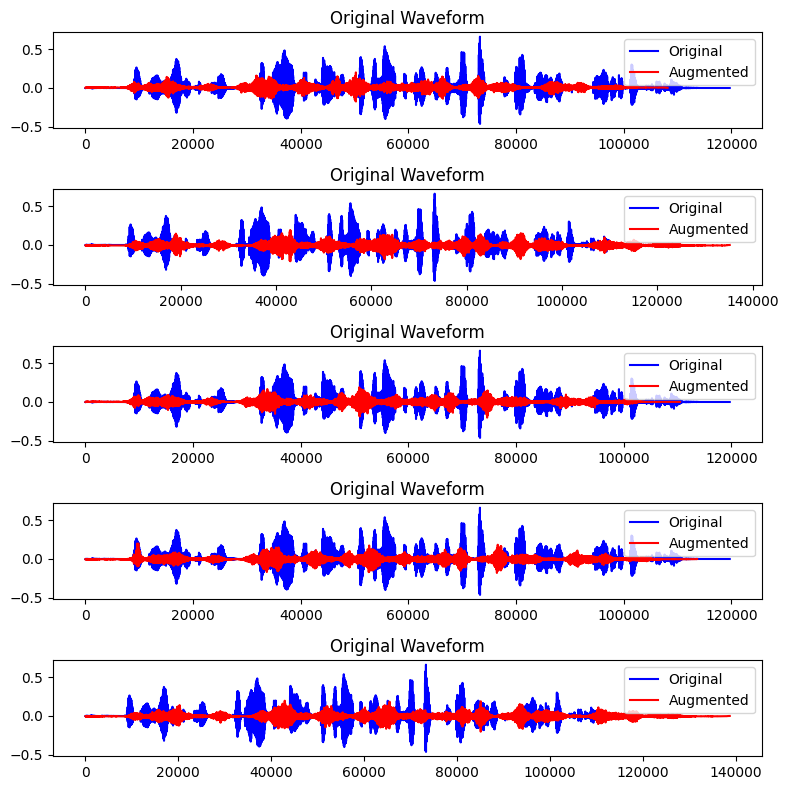

In [ ]:
import torchaudio
import matplotlib.pyplot as plt


# Define some augmentations
def apply_augmentations(y: np.ndarray, sr: int):

    # Randomly choose to add noise
    if np.random.rand() < 1:
        noise = np.random.randn(len(y))
        y = y + 0.005 * noise

    # Randomly choose to apply pitch-shifting
    if np.random.rand() < 1:
        n_steps = np.random.randint(-2, 2)
        y = librosa.effects.pitch_shift(y, sr= sr, n_steps=n_steps)

    # Randomly choose to apply time-stretching
    if np.random.rand() < 1:
        speed_rate = np.random.uniform(0.8, 1.2)
        y = librosa.effects.time_stretch(y, rate=speed_rate)

    # Ensure audio is within [-1, 1]
    y = np.clip(y, -1, 1)

    return y


# Load a sample audio file from torchaudio
waveform, sample_rate = torchaudio.load("/content/drive/MyDrive/Mini_Project/Data (1000files)/Data/Train/000160005.WAV")  # Load the first 1 second of audio

# Plot the original and augmented waveforms
fig, axs = plt.subplots(5, 1, figsize=(8, 8))

for i in range(5):
  # Apply the augmentations
  augmented_waveform = apply_augmentations(waveform.numpy(), sample_rate)

  axs[i].plot(waveform[0].numpy(), label="Original", color='blue')
  axs[i].plot(augmented_waveform[0], label="Augmented", color='red')

  axs[i].set_title("Original Waveform")
  axs[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
import IPython.display as ipd
# ipd.Audio(data=np.asarray(waveform[0]), autoplay=True, rate=16000)
ipd.Audio(data=np.asarray(augmented_waveform[0]), autoplay=True, rate=16000)

In [ ]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.freeze_feature_extractor()


In [ ]:
from datasets import load_metric

def evaluate(model, val_loader, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0

    # Load the WER metric
    wer_metric = load_metric("wer")

    all_transcriptions = []
    all_ground_truths = []

    with torch.no_grad():
        for input_values, labels in val_loader:
            input_values, labels = input_values.to(device), labels.to(device)

            outputs = model(input_values, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            total_samples += input_values.size(0)

            logits = outputs.logits
            # Decode Predictions for Debugging
            predicted_ids = torch.argmax(logits, dim=-1)
            transcription = processor.batch_decode(predicted_ids)
            # Decode the labels to get ground truth
            ground_truth = processor.batch_decode(labels, group_tokens=False )
            cleaned_ground_truth = [i.replace('<unk>', '') for i in ground_truth]
            # Store the transcriptions and ground truth
            all_transcriptions.extend(transcription)
            all_ground_truths.extend(cleaned_ground_truth)

            del input_values, labels, outputs, loss

    avg_loss = total_loss / total_samples

    # Compute WER
    wer = wer_metric.compute(predictions=all_transcriptions, references=all_ground_truths)

    return avg_loss, wer


In [ ]:
vocab_dict = processor.tokenizer.get_vocab()

In [ ]:
# Print out some information about the vocabulary
print(f"Number of tokens in vocab: {len(vocab_dict)}")
print("Example tokens:", list(vocab_dict.keys()))

Number of tokens in vocab: 32
Example tokens: ['<pad>', '<s>', '</s>', '<unk>', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z']


In [ ]:
from datetime import datetime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# DataFrame to store training log
log_df = pd.DataFrame(columns=['epoch', 'train_loss', 'eval_loss', 'wer'])

num_epochs = 35
# tag = datetime.now().strftime('%Y-%m-%d-%H-%M')
tag = 'testing_with_augment_7'
os.makedirs(f"/content/drive/MyDrive/Mini_Project/results/{tag}")
os.makedirs(f"/content/drive/MyDrive/Mini_Project/models/{tag}")

for epoch in range(num_epochs):
    model.train()

    total_train_loss = 0.0
    total_train_samples = 0

    for input_values, labels in train_loader:
        input_values, labels = input_values.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_samples += input_values.size(0)

        # clear memory
        del input_values, labels, outputs, loss

    avg_train_loss = total_train_loss / total_train_samples

    # Evaluation
    avg_eval_loss, wer = evaluate(model, val_loader, device)

    # Logging
    log_df = log_df.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'eval_loss': avg_eval_loss,
        'wer': wer
    }, ignore_index=True)

    print(f"Epoch: {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Eval Loss: {avg_eval_loss:.4f}, WER: {wer}")
    log_df.to_csv(f"/content/drive/MyDrive/Mini_Project/results/{tag}/training_log_testing.csv", index=False)

    # Save the model after 4 epochs
    if (epoch+1) % 5== 0:
      model.save_pretrained(f"/content/drive/MyDrive/Mini_Project/models/{tag}/model_{epoch+1}")
      processor.save_pretrained(f"/content/drive/MyDrive/Mini_Project/models/{tag}/processor_{epoch+1}")

    # Manually run the garbage collector
    gc.collect()

# Save training log to a CSV file
log_df.to_csv(f"/content/drive/MyDrive/Mini_Project/results/{tag}/training_log_testing.csv", index=False)


In [ ]:
# Save the current state of the model after each epoch of training
model.save_pretrained(f"/content/drive/MyDrive/Mini_Project/models/model_{epoch + 1}")

# Save the corresponding processor state after each epoch of training
processor.save_pretrained(f"/content/drive/MyDrive/Mini_Project/models/processor_{epoch + 1}")

#### plot results

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Mini_Project/results/2023-10-15-11-49/training_log_testing.csv")
# df = pd.read_csv("/content/drive/MyDrive/Mini_Project/results/testing_with_augment_2/training_log_testing.csv")
df

,epoch,train_loss,eval_loss,wer
0,1.0,26.545184,13.602555,0.176509
1,2.0,17.629543,12.697292,0.155512
2,3.0,15.173248,10.659895,0.131890
3,4.0,12.083890,11.042910,0.118110
4,5.0,11.251462,10.710064,0.124672
5,6.0,8.336400,10.958165,0.116798
6,7.0,8.374203,12.200518,0.126640
7,8.0,8.380607,11.341901,0.114829
8,9.0,6.902602,12.212177,0.108924
9,10.0,6.735275,12.111967,0.107612


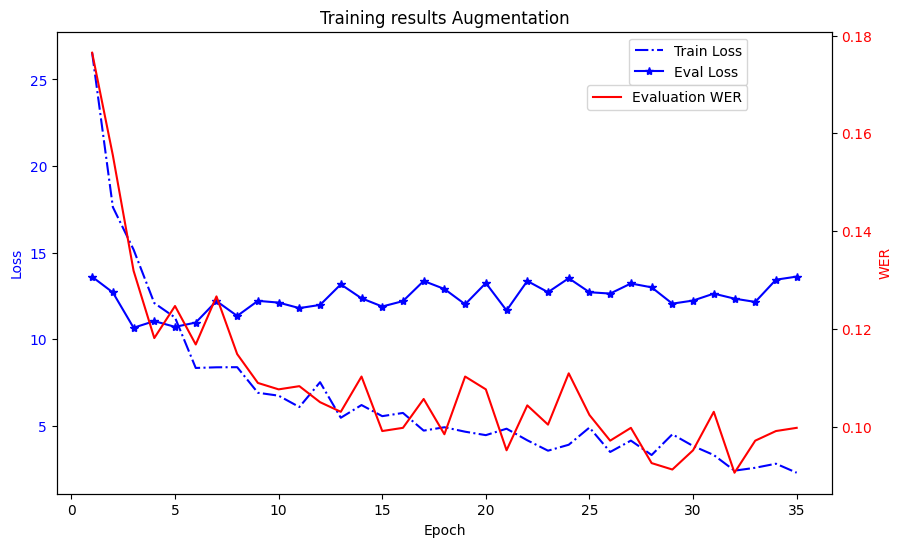

In [ ]:
# Plot training and evaluation loss
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))

# Plot training and evaluation loss
ax1.plot(df['epoch'].astype(int), df['train_loss'], '-.', label='Train Loss', color='b')
ax1.plot(df['epoch'].astype(int), df['eval_loss'], '*-', label='Eval Loss', color='b')

# Label x and y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')

# Set the color of the y-axis label to match the color of the plots
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis to plot WER
ax2 = ax1.twinx()
ax2.plot(df['epoch'].astype(int), df['wer'], '-r', label='Evaluation WER')
ax2.set_ylabel('WER', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
ax1.legend(loc='upper right', bbox_to_anchor=(.9,1))
ax2.legend(loc='upper right', bbox_to_anchor=(.9,0.9))

# Title of the plot
plt.title('Training results Augmentation')

# Display the plot
plt.show()
